In [17]:
%reload_ext autoreload
#!pip install -r requirements.txt

sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]
sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]
384
torch.Size([100, 3])


'cpu'

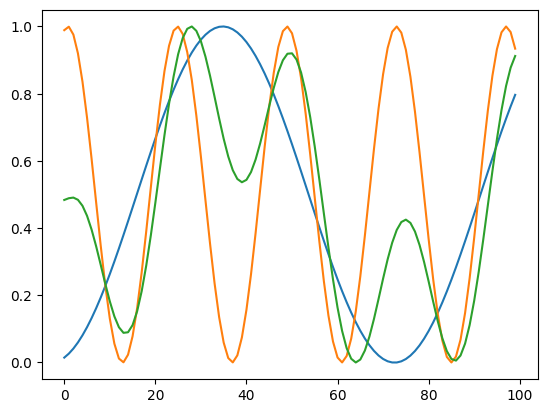

In [18]:
%autoreload
from architectures import COTGAN
from utils import DatasetSinus, log_visualizations
from trainer import cotgan_trainer, cotgan_generator
from metrics import *
import numpy as np
import torch
import matplotlib.pyplot as plt

seed = 42
alpha = 0.7
noise = 0
np.random.seed(seed)
torch.manual_seed(seed)


if torch.backends.mps.is_available(): # run on M1 mac
    device = "mps"
elif torch.cuda.is_available(): # cuda
    device = "cuda"
else:
    device = "cpu"

device = "cpu"
trainset = DatasetSinus(num=32*2*12, seq_len=100, alpha=alpha, noise=noise, device=device)
testset = DatasetSinus(num=32*2*6, seq_len=100, alpha=alpha, noise=noise, device="cpu")

print(len(testset))
print(testset[0][0].size())

plt.plot(trainset[1][0]);
device

In [19]:
%autoreload
import neptune.new as neptune

run = neptune.init_run(
    project="kohmann/COTGAN",
    name="cotgan",
    tags=["tuning"],
    description="",
    source_files=["architectures.py"],
    capture_hardware_metrics=True if device == "cuda" else False,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)

params = {
    "model_name": "model_cotgan.pt",
    "n_epochs": 300,
    "l_rate": 0.001, # for both D and G
    "batch_size": 32,
    "dis_rnn_num_layers": 2,
    #"dis_rnn_hidden_dim": 20,
    "gen_rnn_num_layers": 1,
    "gen_rnn_hidden_dim": 64,
    "hidden_dim": 64, # generator: hidden dim in FC, discriminator: filters in Convolution
    "num_hidden_layers": 2, # generator fully-connected layers

    "scaling_coef": 1.0, # distance scaling (TODO(Not implemented))
    "sinkhorn_eps": 0.8, # epsilon regularizer
    "sinkhorn_l":   100, # sinkhorn calculation iterations
    "reg_lam":      0.01, # martingale penalty coefficient

    "Z_dim": 20,
    "optimizer": "Adam", # RMSprop, Adam
    "beta1": 0.5,
    "beta2": 0.9,
    "dataset": "sines",
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "testset_size": len(testset),
    "device": device,
}

run["parameters"] = params
run["dataset"] = {"alpha":alpha, "noise":noise,
                  "s1_freq": trainset.s1_freq, "s1_phase": trainset.s1_phase,
                  "s2_freq": trainset.s2_freq, "s2_phase": trainset.s2_phase}

model = COTGAN(params)
cotgan_trainer(model, trainset, params, val_dataset=testset, neptune_logger=run, continue_training=False)


# Generate random synthetic data
gen_z = cotgan_generator(model, params)

log_visualizations(testset, gen_z, run) # log pca, tsne, umap, mode_collapse
run["model_checkpoint"].upload("./models/" + params["model_name"])

from metrics import compare_sin3_generation, sw_approx
np.random.seed(seed + 1)
torch.manual_seed(seed + 1)
testset2 = DatasetSinus(num=params["testset_size"], seq_len=params["max_seq_len"], alpha=alpha, noise=noise, device="cpu")
fake_data = cotgan_generator(model, params)

mse_error = compare_sin3_generation(fake_data, alpha, noise)
print(f"MSE Error: {mse_error:.5f}")
x = torch.tensor(fake_data)
y = testset[:][0]
y_2 = testset2[:][0]

sw_baseline = sw_approx(y,y_2)
sw = sw_approx(y,x)

run["numeric_results/num_test_samples"] = len(testset)
run["numeric_results/sin3_generation_MSE_loss"] = mse_error
run["numeric_results/SW"] = sw.item()
run["numeric_results/SW_baseline"] = sw_baseline.item()
run.stop()


https://app.neptune.ai/kohmann/COTGAN/e/COT-131
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


Epoch: 299, G: 12.8044, D: 12.7599: 100%|██████████| 300/300 [21:02<00:00,  4.21s/it]
/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(



Generating Data...Done
Real std:  [0.9586049  0.91026455]
Fake std:  [0.18074197 0.11824995]
sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]

Generating Data...Done
MSE Error: 0.02729
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 26 operations to synchronize with Neptune. Do not kill this process.
All 26 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/COTGAN/e/COT-131
